In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
#Import TensorFlow
import tensorflow as tf
import tensorflow_probability as tfp
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import pickle
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
Normal = tfp.distributions.Normal
from sklearn.preprocessing import StandardScaler
from google.colab import drive, files
from sklearn.metrics import mean_squared_error
drive.mount('/content/gdrive')

2.5.0
Mounted at /content/gdrive


In [3]:
###########################################
#MNIST Example
###########################################
#Load in the data
mnist= tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test)=mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
x_train = x_train.reshape(60000, 784)
scaler = StandardScaler() #Initialize the standardscaler
scaler.fit(x_train)  #Fit the standard scaler
x_train_scaled = scaler.transform(x_train) #Scale the data

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
#Fit the VAE for the selected number of hidden nodes
in_size = 784
hid_size = 0.5*in_size
i=2
dense_1 = Dense(hid_size,activation="relu")
dense_2 = Dense(i)  #For the final encoder layer, activation is linear
dense_3 = Dense(i)
dense_4 = Dense(hid_size, activation="relu")
dense_5 = Dense(in_size)

#Encoder
X = Input(shape=(in_size,))
encode_1 = dense_1(X)
encode_2 = dense_2(encode_1)
encode_3 = dense_3(encode_1)

#we can get sigma (standard dev) > 0 from an unbounded variable by passing it through the softplus function. Add a small amount for smoothing.
means = encode_2[:,:i]
stddev = tf.nn.softplus(encode_3[:,:i]) + 1e-6

#Tensorflow random sampling
Z = Normal(loc=means,scale=stddev).sample()

#Decoder
decode_1 = dense_4(Z)
decode_2 = dense_5(decode_1)

outputs = tf.concat([decode_2, means, stddev],axis=1)
    
def loss(y_true,y_pred):
  decode = y_pred[:,:in_size]
  means = y_pred[:,in_size:in_size+i]
  stddev = y_pred[:,in_size+i:in_size+i*2]
  expected_log_likelihood = -tf.reduce_sum(tf.square(decode-y_true),1)
  kl = tf.reduce_sum(-tf.math.log(stddev) + 0.5*(tf.square(stddev)+ tf.square(means))-0.5, axis=1)
  elbo = tf.reduce_sum(expected_log_likelihood-kl)
  return -elbo

VAE = Model(inputs=X,outputs=outputs)
VAE.compile(loss=loss, optimizer='adam')  # Compile the combined model

In [6]:
r=VAE.fit(x_train_scaled,x_train_scaled,epochs=30,batch_size=32,shuffle=True)

Epoch 1/30
1875/1875 [==============================] - 8s 2ms/step - loss: 21084.8887
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 20597.8867
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 19446.2695
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 19348.6758
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 18660.7930
Epoch 6/30
1875/1875 [==============================] - 4s 2ms/step - loss: 19776.3828
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - loss: 18781.4473
Epoch 8/30
1875/1875 [==============================] - 4s 2ms/step - loss: 17946.0957
Epoch 9/30
1875/1875 [==============================] - 4s 2ms/step - loss: 17692.9609
Epoch 10/30
1875/1875 [==============================] - 4s 2ms/step - loss: 17878.8613
Epoch 11/30
1875/1875 [==============================] - 4s 2ms/step - loss: 17639.3086
Epoch 12/30
1875/1875 [==================

In [7]:
#Create decoder model
encoded_input = Input(shape=(2,))
decode_1 = dense_4(encoded_input)
decode_2 = dense_5(decode_1)
decoder = Model(inputs=encoded_input,outputs=decode_2)

In [ ]:
#Plot what image is reproduced for different parts of Z
n = 19 # number of images per side
x_values = np.linspace(-3,3,n)
y_values = np.linspace(-3,3,n)
image = np.empty((28*n,28*n))

#build Z first so we don't have to keep re-calling the predict function
Z2 = []
for i, x in enumerate(x_values):
  for j, y in enumerate(y_values):
    z = [x,y]
    Z2.append(z)
X_recon = scaler.inverse_transform(decoder.predict(Z2))

k = 0
for i, x in enumerate(x_values):
  for j, y in enumerate(y_values):
    x_recon = X_recon[k]
    k += 1
    #convert from NxD == 1 x 784 --> 28 x 28
    x_recon = x_recon.reshape(28, 28)
    image[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = (x_recon > 0.4)

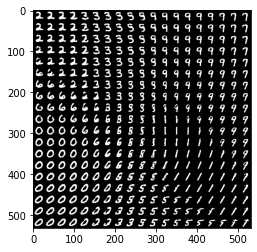

In [14]:
plt.imshow(image, cmap='gray')

In [3]:
##########################################################################################
#Train the VAE using Plaxis simulated embankment responses
##########################################################################################

#Load the data
M0 = np.array(pd.read_csv('/content/gdrive/My Drive/M0_simulated.csv',header=None))
M1 = np.array(pd.read_csv('/content/gdrive/My Drive/M1_simulated.csv',header=None))
M2 = np.array(pd.read_csv('/content/gdrive/My Drive/M2_simulated.csv',header=None))
M3 = np.array(pd.read_csv('/content/gdrive/My Drive/M3_simulated.csv',header=None))
HPG1_1 = np.array(pd.read_csv('/content/gdrive/My Drive/HPG1_1_simulated.csv',header=None))
HPG1_2 = np.array(pd.read_csv('/content/gdrive/My Drive/HPG1_2_simulated.csv',header=None))
HPG1_3 = np.array(pd.read_csv('/content/gdrive/My Drive/HPG1_3_simulated.csv',header=None))
VWP6b = np.array(pd.read_csv('/content/gdrive/My Drive/VWP6b_ex_simulated.csv',header=None))
VWP6c = np.array(pd.read_csv('/content/gdrive/My Drive/VWP6c_ex_simulated.csv',header=None))

x_data = np.vstack((M0,M1,M2,M3,HPG1_1,HPG1_2,HPG1_3,VWP6b,VWP6c)).T
print("x_data.shape:",x_data.shape)

#Scale the data using standardscalar
scaler = StandardScaler() #Initialize the standardscaler
scaler.fit(x_data)  #Fit the standard scaler
x_data_scaled = scaler.transform(x_data) #Scale the data
with open(f'scaler.pkl', 'wb') as f:
  pickle.dump(scaler, f)  #Save the standard scalar

x_data.shape: (300, 1170)


In [12]:
#Reconstruction error against number of latent nodes
reconstruct_err = np.zeros(10)
for i in range (1,11):
  in_size = 1170 #Size of input layer
  hid_size = 0.5*in_size  #Size of hidden layer
  dense_1 = Dense(hid_size,activation="relu")
  dense_2 = Dense(i)
  dense_3 = Dense(i)
  dense_4 = Dense(hid_size, activation="relu")
  dense_5 = Dense(in_size)

  #encoder
  X = Input(shape=(in_size,))
  encode_1 = dense_1(X)
  encode_2 = dense_2(encode_1)
  encode_3 = dense_3(encode_1)

  means = encode_2[:,:i]
  stddev = tf.nn.softplus(encode_3[:,:i]) + 1e-6

  Z = Normal(loc=means,scale=stddev).sample()

  #Decoder 
  decode_1 = dense_4(Z)
  decode_2 = dense_5(decode_1)

  outputs = tf.concat([decode_2, means, stddev],axis=1)

  def loss(y_true,y_pred):
    decode = y_pred[:,:in_size]
    means = y_pred[:,in_size:in_size+i]
    stddev = y_pred[:,in_size+i:in_size+i*2]
    expected_log_likelihood = -tf.reduce_sum(tf.square(decode-y_true),1)
    kl = tf.reduce_sum(-tf.math.log(stddev) + 0.5*(tf.square(stddev)+ tf.square(means))-0.5, axis=1)
    elbo = tf.reduce_sum(expected_log_likelihood-kl)
    return -elbo

  VAE = Model(inputs=X,outputs=outputs)
  VAE.compile(loss=loss, optimizer='adam')  # Compile the combined model

  r=VAE.fit(x_data_scaled,x_data_scaled,epochs=1000,batch_size=32,shuffle=True)

  #Evalute reconstruction error
  reconstructed_data = VAE.predict(x_data_scaled)[:,:in_size]
  reconstruct_err[i-1]= mean_squared_error(x_data_scaled,reconstructed_data[:,:in_size])

串流輸出內容已截斷至最後 5000 行。
Epoch 501/1000
10/10 [==============================] - 0s 4ms/step - loss: 782.4054
Epoch 502/1000
10/10 [==============================] - 0s 4ms/step - loss: 753.0625
Epoch 503/1000
10/10 [==============================] - 0s 4ms/step - loss: 727.6721
Epoch 504/1000
10/10 [==============================] - 0s 4ms/step - loss: 735.5627
Epoch 505/1000
10/10 [==============================] - 0s 5ms/step - loss: 734.5968
Epoch 506/1000
10/10 [==============================] - 0s 4ms/step - loss: 724.4308
Epoch 507/1000
10/10 [==============================] - 0s 4ms/step - loss: 752.9377
Epoch 508/1000
10/10 [==============================] - 0s 4ms/step - loss: 743.1047
Epoch 509/1000
10/10 [==============================] - 0s 5ms/step - loss: 738.9824
Epoch 510/1000
10/10 [==============================] - 0s 4ms/step - loss: 756.6401
Epoch 511/1000
10/10 [==============================] - 0s 4ms/step - loss: 730.5751
Epoch 512/1000
10/10 [======================

[0.22576971 0.06160438 0.01891629 0.00857433 0.00593392 0.00421138
 0.00489568 0.00410338 0.00473573 0.00550428]


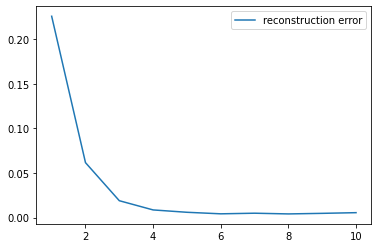

In [14]:
print(reconstruct_err)
plt.plot(range(1,11),reconstruct_err,label='reconstruction error')
plt.legend()

In [5]:
#Fit VAE again using the selected number of latent nodes
in_size = 1170  #Size of input layer
hid_size = 0.5*in_size  #Size of hidden layer
i=6
dense_1 = Dense(hid_size,activation="relu")
dense_2 = Dense(i) 
dense_3 = Dense(i)
dense_4 = Dense(hid_size, activation="relu")
dense_5 = Dense(in_size)

#encoder
X = Input(shape=(in_size,))
encode_1 = dense_1(X)
encode_2 = dense_2(encode_1)
encode_3 = dense_3(encode_1)

means = encode_2[:,:i]
stddev = tf.nn.softplus(encode_3[:,:i]) + 1e-6

Z = Normal(loc=means,scale=stddev).sample()

#Decoder
decode_1 = dense_4(Z)
decode_2 = dense_5(decode_1)

outputs = tf.concat([decode_2, means, stddev],axis=1)
    
def loss(y_true,y_pred):
  decode = y_pred[:,:in_size]
  means = y_pred[:,in_size:in_size+i]
  stddev = y_pred[:,in_size+i:in_size+i*2]
  expected_log_likelihood = -tf.reduce_sum(tf.square(decode-y_true),1)
  kl = tf.reduce_sum(-tf.math.log(stddev) + 0.5*(tf.square(stddev)+ tf.square(means))-0.5, axis=1)
  elbo = tf.reduce_sum(expected_log_likelihood-kl)
  return -elbo

VAE = Model(inputs=X,outputs=outputs)
VAE.compile(loss=loss, optimizer='adam')  # Compile the combined model

In [6]:
r=VAE.fit(x_data_scaled,x_data_scaled,epochs=5000,batch_size=32,shuffle=True)

串流輸出內容已截斷至最後 5000 行。
Epoch 2501/5000
10/10 [==============================] - 0s 4ms/step - loss: 519.8919
Epoch 2502/5000
10/10 [==============================] - 0s 5ms/step - loss: 514.8269
Epoch 2503/5000
10/10 [==============================] - 0s 4ms/step - loss: 524.7137
Epoch 2504/5000
10/10 [==============================] - 0s 4ms/step - loss: 542.0533
Epoch 2505/5000
10/10 [==============================] - 0s 4ms/step - loss: 532.6356
Epoch 2506/5000
10/10 [==============================] - 0s 4ms/step - loss: 528.0060
Epoch 2507/5000
10/10 [==============================] - 0s 4ms/step - loss: 534.4725
Epoch 2508/5000
10/10 [==============================] - 0s 5ms/step - loss: 527.5117
Epoch 2509/5000
10/10 [==============================] - 0s 5ms/step - loss: 518.2170
Epoch 2510/5000
10/10 [==============================] - 0s 4ms/step - loss: 512.6621
Epoch 2511/5000
10/10 [==============================] - 0s 4ms/step - loss: 509.4642
Epoch 2512/5000
10/10 [==========

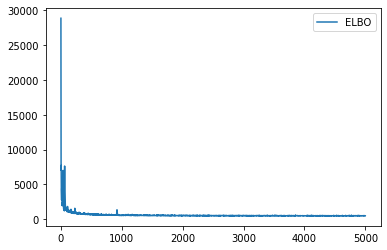

In [9]:
plt.plot(r.history['loss'], label = 'ELBO')
plt.legend()

In [10]:
pd.DataFrame(r.history['loss']).to_csv('/content/gdrive/My Drive/ELBO.csv', index=False, header=False) #Save the ELBO during training

In [ ]:
#Create and save the encoder model
encoder = Model(inputs=X,outputs=means)
encoder.save_weights('/content/gdrive/My Drive/encoder_vae.h5') #Save the weights of the encoder
post_sd_network = Model(inputs=X,outputs=stddev)
post_sd_network.save_weights('/content/gdrive/My Drive/post_sd_vae.h5') #Save the weights of the SD network

In [ ]:
#Create and save the decoder model
encoded_input = Input(shape=(6,)) #Change this line to match the size of latent space
decode_1 = dense_4(encoded_input)
decode_2 = dense_5(decode_1)
decoder = Model(inputs=encoded_input,outputs=decode_2)
decoder.save_weights('/content/gdrive/My Drive/decoder_vae.h5') #Save the weights of the decoder

In [ ]:
#########################################################################################
#Gibbs sampling for the predicted response
#########################################################################################
#load actual data
M_smooth = np.array(pd.read_csv('/content/gdrive/My Drive/M_actual_data_smooth.csv',header=None))
HPG1_smooth = np.array(pd.read_csv('/content/gdrive/My Drive/HPG1_actual_data_smooth.csv',header=None))
VWP_smooth = -np.array(pd.read_csv('/content/gdrive/My Drive/VWP_ex_actual_data_smooth.csv',header=None))
print("M_data.shape:", M_smooth.shape)
print("HPG1_data.shape:", HPG1_smooth.shape)
print("VWP_data.shape:", VWP_smooth.shape)

M_smooth.shape: (92, 5)
HPG1_smooth.shape: (40, 7)
VWP_smooth.shape: (92, 4)


In [ ]:
#Load the encoder, SD network and decoder
encoder = Model(inputs=X,outputs=means)
encoder.load_weights('/content/gdrive/My Drive/encoder_vae.h5') #Load the weights of the encoder

post_sd_network = Model(inputs=X,outputs=stddev)
post_sd_network.load_weights('/content/gdrive/My Drive/post_sd_vae.h5')

encoded_input = Input(shape=(6,)) #Change this line to match the size of the latent space
decode_1 = dense_4(encoded_input)
decode_2 = dense_5(decode_1)
decoder = Model(inputs=encoded_input,outputs=decode_2)
decoder.load_weights('/content/gdrive/My Drive/decoder_vae.h5') #Load the weights of the decoder

with open(f'scaler.pkl', 'wb') as f:
  pickle.load(scaler, f)  #Load the standard scalar

In [ ]:
####Index of measured and predicted data. Comment and uncomment the correponding sections
###Base case (15 Oct 2013 - 27 Jun 2014)
x_data_actual = np.vstack((M_smooth[:,1:5],,HPG1_smooth[:,1:2],VWP_smooth[:,2:4])).T
index_actual = np.hstack((range(1,106),range(176,281),range(351,456),range(526,631),range(701,741),range(821,926),range(996,1101)))-1
index_predict = np.hstack((range(106,176),range(281,351),range(456,526),range(631,701),range(741,821),range(926,996),range(1101,1171)))-1

###Shorter time period (15 Oct 2013 - 31 Jan 2014)
#x_data_actual = np.vstack((M_smooth[:,1:5],,HPG1_smooth[:,1:2],VWP_smooth[:,2:4])).T
#index_actual = np.hstack((range(1,56),range(176,231),range(351,406),range(526,581),range(701,741),range(821,876),range(996,1051)))-1
#index_predict = np.hstack((range(56,176),range(231,351),range(406,526),range(581,701),range(741,821),range(876,996),range(1051,1171)))-1

###Longer time period (15 Oct 2013 - 31 Oct 2014)
#x_data_actual = np.vstack((M_smooth[:,1:5],,HPG1_smooth[:,1:3],VWP_smooth[:,2:4])).T
#index_actual = np.hstack((range(1,132),range(176,307),range(351,482),range(526,657),range(701,781),range(821,952),range(996,1127)))-1
#index_predict = np.hstack((range(132,176),range(307,351),range(482,526),range(657,701),range(781,821),range(952,996),range(1127,1171)))-1

#Use standardscaler to scale actual data
mean_scalar = scaler.mean_[index_actual]
std_scalar = scaler.scale_[index_actual]
x_data_actual_scaled = (x_data_actual-mean_scalar)/std_scalar #Scale the data

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91  187  188  189  190  191  192
  193  194  195  196  197  198  199  200  201  202  203  204  205  206
  207  208  209  210  211  212  213  214  215  216  217  218  219  220
  221  222  223  224  225  226  227  228  229  230  231  232  233  234
  235  236  237  238  239  240  241  242  243  244  245  246  247  248
  249  250  251  252  253  254  255  256  257  258  259  260  261  262
  263  264  265  266  267  268  269  270  271  272  273  274  275  276
  277  278  374  375  376  377  378  379  380  381  382  383  384  385
  386 

In [ ]:
#Gibbs sampling with multiple Markov Chains 
N = 10 #Number of Markov Chains
T = 3000 #Length of Meach earkov Chain
I = 1362 #Input size
M = 8 #Size of latent space
z_gibbs = np.zeros((M,T,N))
x_gibbs = np.zeros((I,T))

for j in range(N):
  Z = Normal(loc=np.zeros(M,dtype=np.float32),scale=np.ones(M,dtype=np.float32)).sample()
  x_decode_mean = decoder.predict(tf.reshape(Z,[-1,M]))
  if j == (N-1):
    x_gibbs[:,0] = np.array(x_decode_mean)
  x_decode = np.array(Normal(loc=np.array(x_decode_mean),scale=np.ones(I,dtype=np.float32)).sample())
  x_decode[:,index_actual] = x_data_actual_scaled
  z_gibbs[:,0,j] = np.array(Z)
  for i in range(1,T):
    means_whole = encoder.predict(tf.reshape(x_decode,[-1,I]))
    sd_whole = post_sd_network.predict(tf.reshape(x_decode,[-1,I]))
    Z = Normal(loc=means_whole,scale=sd_whole).sample() 
    z_gibbs[:,i,j] = np.array(Z)
    x_decode_mean = decoder.predict(tf.reshape(Z,[-1,M]))
    if j == (N-1):
     x_gibbs[:,i] = np.array(x_decode_mean)
    x_decode = np.array(Normal(loc=np.array(x_decode_mean),scale=np.ones(I,dtype=np.float32)).sample())
    x_decode[:,index_actual] = x_data_actual_scaled
  print(j)

500
1000
1500
2000
2500
500
1000
1500
2000
2500
500
1000
1500
2000
2500
500
1000
1500
2000
2500
500
1000
1500
2000
2500
500
1000
1500
2000
2500
500
1000
1500
2000
2500
500
1000
1500
2000
2500
500
1000
1500
2000
2500
500
1000
1500
2000
2500


In [ ]:
#Save the Gibbs samples
z_gibbs_reshape = np.reshape(z_gibbs,(M,-1))
print(z_gibbs_reshape.shape) #First T columns are from the first Markov Chain, the next T columns are the second chain, and so on. 
pd.DataFrame(np.transpose(z_gibbs_reshape)).to_csv('/content/gdrive/My Drive/z_gibbs_multiple.csv', index=False, header=False) #Save the z Gibbs samples
pd.DataFrame(np.transpose(x_gibbs)).to_csv('/content/gdrive/My Drive/x_gibbs.csv', index=False, header=False) #Save the x Gibbs samples

(8, 30000)


In [ ]:
#Inverse scale back the x Gibbs samples, and partition them
resconstruted_response = scaler.inverse_transform(np.transpose(x_gibbs))

size1 = 175
size2 = 40
size3 = 175

M0_resconstruted = resconstruted_response[:,0:size1]
M1_resconstruted = resconstruted_response[:,size1:size1*2]
M2_resconstruted = resconstruted_response[:,size1*2:size1*3]
M3_resconstruted = resconstruted_response[:,size1*3:size1*4]

HPG1_1_resconstruted = resconstruted_response[:,size1*4:size1*4+size2]
HPG1_2_resconstruted = resconstruted_response[:,size1*4+size2:size1*4+size2*2]
HPG1_3_resconstruted = resconstruted_response[:,size1*4+size2*2:size1*4+size2*3]

VWP6b_resconstruted = resconstruted_response[:,size1*4+size2*3:size1*4+size2*3+size3]
VWP6c_resconstruted = resconstruted_response[:,size1*4+size2*3+size3:size1*4+size2*3+size3*2]

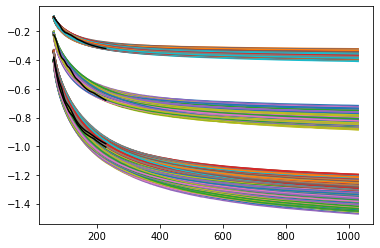

In [ ]:
#Plot the settlement predictions
plt.plot(M_smooth[:,0], M_smooth[:,1],'k')
plt.plot(M_smooth[:,0], M_smooth[:,2],'k')
plt.plot(M_smooth[:,0], M_smooth[:,3],'k')
plt.plot(M_smooth[:,0], M_smooth[:,4],'k')

time_steps = np.hstack((np.array([75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,96,97,98,100,101,102,103,105,106,108,110,111,112,113,115,116,117,118,120,121,122,123,125,126,128,131,133,136,138,141,143,146,148,151,154,155,156,157,158,161,166,171,176,181,186,191,194,196,197,199,200,202,205,210,215,218,220,223,225,228,233,238,243,246,248,251,253,256,258,261,263,266,271,276,281,286,295,297,302,307,312,317,320,322,327]),np.linspace(330,490,num=33),np.linspace(500,670,num=18),np.linspace(680,1020,num=18),1030)) 
for index in range(2000,3000):
  plt.plot(time_steps, M0_resconstruted[index,:])
  plt.plot(time_steps, M1_resconstruted[index,:])
  plt.plot(time_steps, M2_resconstruted[index,:])
  plt.plot(time_steps, M3_resconstruted[index,:])

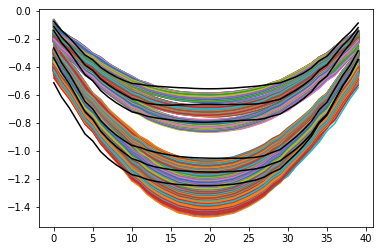

In [ ]:
#Plot the HPG1 predictions
space_steps = np.array([-13.02,-12.32,-11.76,-11.04,-10.24,-9.76,-8.96,-8.32,-7.68,-7.04,-6.24,-5.76,-4.96,-4.32,-3.68,-3.04,-2.24,-1.76,-0.96,-0.32,0.32,0.96,1.76,2.24,3.04,3.68,4.32,4.96,5.76,6.24,7.04,7.68,8.32,8.96,9.76,10.24,11.04,11.76,12.32,13.02])

for index in range(2000,3000):
  plt.plot(space_steps, HPG1_1_resconstruted[index,:])
  plt.plot(space_steps, HPG1_2_resconstruted[index,:])
  plt.plot(space_steps, HPG1_3_resconstruted[index,:])
  plt.plot(space_steps, HPG1_4_resconstruted[index,:])
  plt.plot(space_steps, HPG1_5_resconstruted[index,:])
  plt.plot(space_steps, HPG1_6_resconstruted[index,:])

plt.plot(space_steps, HPG1_smooth[:,1],'k')
plt.plot(space_steps, HPG1_smooth[:,2],'k')
plt.plot(space_steps, HPG1_smooth[:,3],'k')
plt.plot(space_steps, HPG1_smooth[:,4],'k')
plt.plot(space_steps, HPG1_smooth[:,5],'k')
plt.plot(space_steps, HPG1_smooth[:,6],'k')

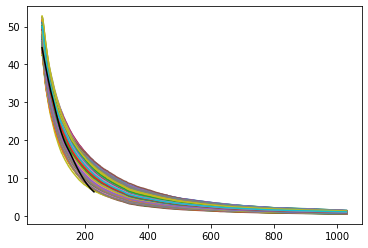

In [ ]:
#Plot the VWP6b predictions
plt.plot(VWP_smooth[:,0], VWP_smooth[:,2],'k')
time_steps = np.hstack((np.array([75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,96,97,98,100,101,102,103,105,106,108,110,111,112,113,115,116,117,118,120,121,122,123,125,126,128,131,133,136,138,141,143,146,148,151,154,155,156,157,158,161,166,171,176,181,186,191,194,196,197,199,200,202,205,210,215,218,220,223,225,228,233,238,243,246,248,251,253,256,258,261,263,266,271,276,281,286,295,297,302,307,312,317,320,322,327]),np.linspace(330,490,num=33),np.linspace(500,670,num=18),np.linspace(680,1020,num=18),1030)) 
for index in range(2000,3000):
  plt.plot(time_predict, -VWP6b_resconstruted[index,:])

In [ ]:
#Plot the VWP6c predictions
plt.plot(VWP_smooth[:,0], VWP_smooth[:,3],'k')
time_steps = np.hstack((np.array([75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,96,97,98,100,101,102,103,105,106,108,110,111,112,113,115,116,117,118,120,121,122,123,125,126,128,131,133,136,138,141,143,146,148,151,154,155,156,157,158,161,166,171,176,181,186,191,194,196,197,199,200,202,205,210,215,218,220,223,225,228,233,238,243,246,248,251,253,256,258,261,263,266,271,276,281,286,295,297,302,307,312,317,320,322,327]),np.linspace(330,490,num=33),np.linspace(500,670,num=18),np.linspace(680,1020,num=18),1030)) 
for index in range(2000,3000):
  plt.plot(time_predict, -VWP6c_resconstruted[index,:])